In [1]:
from tensorflow import keras

2023-03-20 20:24:32.107770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 20:24:32.330138: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# A first look at a neural network

###This notebook contains the code samples found in Chapter 2, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). 

#####Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.
------------------
###note: The code was slightly modified to match new versions of Keras
-----------------
----

We will now take a look at a first concrete example of a neural network, which makes use of the Python library Keras to learn to classify 
hand-written digits. Unless you already have experience with Keras or similar libraries, you will not understand everything about this 
first example right away. You probably haven't even installed Keras yet. Don't worry, that is perfectly fine. In the next chapter, we will 
review each element in our example and explain them in detail. So don't worry if some steps seem arbitrary or look like magic to you! 
We've got to start somewhere.

The problem we are trying to solve here is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 
categories (0 to 9). The dataset we will use is the MNIST dataset, a classic dataset in the machine learning community, which has been 
around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test 
images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. You can think of "solving" MNIST 
as the "Hello World" of deep learning -- it's what you do to verify that your algorithms are working as expected. As you become a machine 
learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.

The MNIST dataset comes pre-loaded in Keras, in the form of a set of four Numpy arrays:

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Import the data
filepath = '/home/shua/Desktop/msc-ml-datamining/DeepLearning/Data/mnist.npz'

In [4]:
#To load this dataset in your code use following function
import numpy as np
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
    return (x_train, y_train), (x_test, y_test)

(train_images, train_labels), (test_images, test_labels) = load_data(filepath)

`train_images` and `train_labels` form the "training set", the data that the model will learn from. The model will then be tested on the 
"test set", `test_images` and `test_labels`. Our images are encoded as Numpy arrays, and the labels are simply an array of digits, ranging 
from 0 to 9. There is a one-to-one correspondence between the images and the labels.

Let's have a look at the training data:

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
train_images[1003].shape

(28, 28)

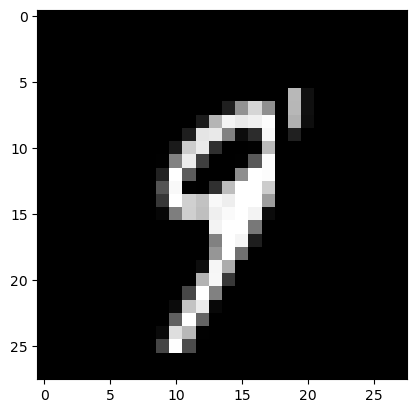

In [7]:
import matplotlib.pyplot as plt
plt.imshow(train_images[1027],cmap='gray')

In [8]:
train_labels[1027]

9

Let's have a look at the test data:

In [9]:
test_images.shape

(10000, 28, 28)

In [10]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

Our workflow will be as follow: first we will present our neural network with the training data, `train_images` and `train_labels`. The 
network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_images`, and we 
will verify if these predictions match the labels from `test_labels`.

Let's build our network *(we will use a tiny NN for simplicity)* -- again, remember that you aren't supposed to understand everything about this example just yet.

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=8, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 dense (Dense)               (None, 10)                13530     
                                                                 
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________


The core building block of neural networks is the "layer", a data-processing module which you can conceive as a "filter" for data. Some 
data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them -- hopefully 
representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers 
which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a 
succession of increasingly refined data filters -- the "layers".

Here our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 
The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each 
score will be the probability that the current digit image belongs to one of our 10 digit classes.

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be 
able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly 
classified).

The exact purpose of the loss function and the optimizer will be made clear throughout the next two chapters.

Compile model

In [13]:
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])


Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in 
the `[0, 1]` interval. Previously, our training images for instance were stored in an array of shape `(60000, 28, 28)` of type `uint8` with 
values in the `[0, 255]` interval. We transform it into a `float32` array of shape `(60000, 28 , 28 , 1)` with values between 0 and 1.

In [14]:
train_images.shape

(60000, 28, 28)

In [15]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

In [16]:
train_images.shape

(60000, 28, 28, 1)

We are now ready to train our network, which in Keras is done via a call to the 

---

`fit` method of the network: 
we "fit" the model to its training data.

In [17]:
model.fit(train_images, train_labels, epochs=3, batch_size=128)

Epoch 1/3
469/469 [==============================] - 2s 3ms/step - loss: 0.4590 - accuracy: 0.8760
Epoch 2/3
469/469 [==============================] - 1s 3ms/step - loss: 0.2607 - accuracy: 0.9251
Epoch 3/3
469/469 [==============================] - 2s 3ms/step - loss: 0.2105 - accuracy: 0.9399


Two quantities are being displayed during training: the "loss" of the network over the training data, and the accuracy of the network over 
the training data.

We quickly reach an accuracy of 0.98 (i.e. 98%) on the training data. Now let's check that our model performs well on the test set too:

In [18]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 0s 775us/step - loss: 0.1766 - accuracy: 0.9507
Test accuracy: 0.951


Shua: Now going to try with a couple more epochs

In [23]:
#first need to reinstaniate the model
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4454 - accuracy: 0.8883
Epoch 2/5
469/469 [==============================] - 2s 3ms/step - loss: 0.1814 - accuracy: 0.9491
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1229 - accuracy: 0.9660
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0968 - accuracy: 0.9730
Epoch 5/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0826 - accuracy: 0.9767


(The loss after 4 epochs doesn't really increase so much, so training more may just lead to overfitting.)

# (Performance values depend on the run, NNs are not deterministic!)

Our test set accuracy turns out to be 97.8% -- that's quite a bit lower than the training set accuracy. 
This gap between training accuracy and test accuracy is an example of "overfitting", 
the fact that machine learning models tend to perform worse on new data than on their training data. 
Overfitting will be a central topic in chapter 3.

This concludes our very first example -- you just saw how we could build and a train a neural network to classify handwritten digits, in 
less than 20 lines of Python code. In the next chapter, we will go in detail over every moving piece we just previewed, and clarify what is really 
going on behind the scenes. You will learn about "tensors", the data-storing objects going into the network, about tensor operations, which 
layers are made of, and about gradient descent, which allows our network to learn from its training examples.

## Compare with ML

In [24]:
train_flat = train_images.reshape((len(train_images), -1))
test_flat = test_images.reshape((len(test_images), -1))

In [25]:
train_flat[0].shape

(784,)

In [26]:
train_flat[0][:200]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [27]:
from sklearn.linear_model import LogisticRegression# Turn up tolerance for faster convergence
clf = LogisticRegression(tol=0.1)

In [28]:
# Learn the digits on the train subset
clf.fit(train_flat, train_labels)

/home/shua/miniconda3/envs/lev_ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(tol=0.1)

In [29]:
#number of coefficients
#Note that the NN has much more parameters
clf.coef_.shape
#multi class = 10 * 784

(10, 784)

#most of the coefficients are close to zero
#This is because of image pixel correlation:
#Pure ML see each pixel as a feature, which is not efficient

(array([3.000e+00, 4.000e+00, 1.200e+01, 1.700e+01, 4.600e+01, 1.070e+02,
        2.460e+02, 4.570e+02, 8.490e+02, 3.506e+03, 1.103e+03, 7.000e+02,
        4.510e+02, 2.150e+02, 7.300e+01, 2.400e+01, 1.200e+01, 7.000e+00,
        1.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00]),
 array([-1.52663096, -1.37169748, -1.21676399, -1.0618305 , -0.90689702,
        -0.75196353, -0.59703005, -0.44209656, -0.28716307, -0.13222959,
         0.0227039 ,  0.17763739,  0.33257087,  0.48750436,  0.64243784,
         0.79737133,  0.95230482,  1.1072383 ,  1.26217179,  1.41710527,
         1.57203876,  1.72697225,  1.88190573,  2.03683922,  2.1917727 ,
         2.34670619]),
 <BarContainer object of 25 artists>)

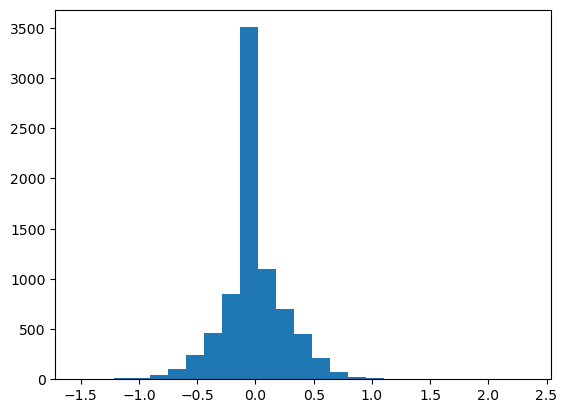

In [30]:
plt.hist(clf.coef_.reshape(-1),bins=25)

In [31]:
# Predict the value of the digits on the test subset
acc = clf.score(test_flat, test_labels)
print(acc)

0.9256


## ~ 92% accuracy; pca reduces fit time and improves accuracy a bit



##### BTW: you can implement a logistic regression as a single NN layer

In [32]:
inputs = keras.Input(shape=(28*28))
outputs = layers.Dense(10, activation="softmax")(inputs)
model_lr = keras.Model(inputs=inputs, outputs=outputs)

model_lr.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [33]:
model_lr.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [34]:
model_lr.fit(train_flat, train_labels, epochs=3, batch_size=128)

Epoch 1/3
469/469 [==============================] - 1s 946us/step - loss: 0.6050 - accuracy: 0.8499
Epoch 2/3
469/469 [==============================] - 0s 962us/step - loss: 0.3313 - accuracy: 0.9073
Epoch 3/3
469/469 [==============================] - 0s 944us/step - loss: 0.3020 - accuracy: 0.9153


In [35]:
print(model_lr.metrics_names)
model_lr.evaluate(test_flat,test_labels)

['loss', 'accuracy']
313/313 [==============================] - 0s 716us/step - loss: 0.2863 - accuracy: 0.9192


[0.28628775477409363, 0.9192000031471252]

##Improvements ..... from ML to DL
##Read Chapter 1 from book: What is deep learning?


How to score 97%, 98%, 99%, and 100%
https://www.kaggle.com/c/digit-recognizer/discussion/61480

Computer Vision

92%: Multinomial logistic regression aka softmax regression is a simple first attempt scoring 92%.
97%: Non-linear methods will score 97%. These include kNN, random forest, etc
98%: SVM with a nonlinear kernel, or a fully connected neural network is the next thing that people try. If tuned well, these methods can climb to 99%. Add preprocessing and they can go a little higher.
99%: Convolutional neural networks are the champions in image classification. If you simply add one layer of conv filters to your fully connected NN (before the dense layers), you'll beat 99%. For example in Keras:
model.add(Conv2D(filters=32,kernel_size=5,activation='relu')) The simple network 784-32C5-500-10 with dropout achieves 99% after 30 epochs. (Add a pooling layer and it gets there in 15 epochs.)
99.5%: If you design a good CNN architecture and then add special features like pooling layers, data augmentation, dropout, batch normalization, decaying learning rate, advanced optimization; You'll have no problem breaking the landmark 99.5% in only 20 epochs! Example here
Best Design: The best design is to start with convolution layer(s), then add a pooling layer. Then add convolution layer(s), then another pooling. Then add dense layer(s). Finish with softmax. There are many wonderful tutorials on Kaggle. Here's a simple schematic (from LeNet5):

On the histogram above, you can see that there is a spike at 99% and 99.5%. These correspond to people using CNNs and then tuning their CNNs. The best CNNs score 99.6%.

99.7%: To break 99.7%, you need to make a great CNN. (And use a GPU so it doesn't take forever to train). Then if you train it 10 times and make 10 submissions, one of those will probably beat 99.7%. (Each time you train a CNN, you get a different result) If you only want to run your kernel once and make one submission, then build an ensemble of your great CNNs and it will score over 99.7% everytime. Example here.
Best Accuracy: The most accurate Kaggle kernel achieves 99.75% here. (The best anywhere is 99.79% listed here)
99.8%: To score 99.8% and higher, you need to have an incredibly lucky training session, or you need to train with the full original MNIST dataset of 70,000 images which unfairly contains Kaggle's "test.csv" images.
99.9%: You must train with the full original MNIST dataset of 70,000 images
100.0%: You must train with the full original MNIST dataset of 70,000 images. Here's a Kaggle kernel that scores 100%.

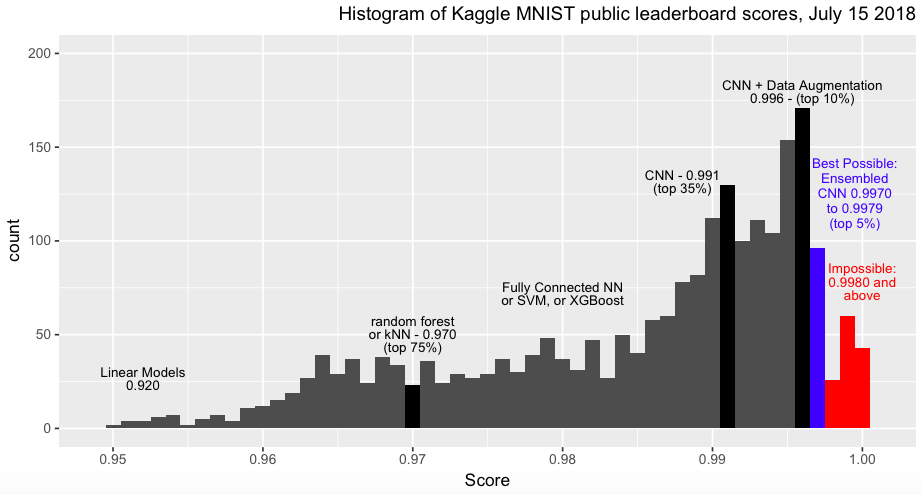

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/Machon Lev/DL_5782/Notebooks/Data/img1.png')

Shua: Going to try a more complex model now

In [42]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=8, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=8, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=8, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [43]:
#lets try a different optimizer and add a learning rate scheduler
#define the learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
#compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [44]:
model.fit(train_images, train_labels, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.6535 - accuracy: 0.7892
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.3535 - accuracy: 0.8942
Epoch 3/10
469/469 [==============================] - 3s 5ms/step - loss: 0.3019 - accuracy: 0.9106
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2708 - accuracy: 0.9202
Epoch 5/10
469/469 [==============================] - 3s 5ms/step - loss: 0.2461 - accuracy: 0.9270
Epoch 6/10
469/469 [==============================] - 3s 5ms/step - loss: 0.2308 - accuracy: 0.9315
Epoch 7/10
469/469 [==============================] - 3s 5ms/step - loss: 0.2135 - accuracy: 0.9366
Epoch 8/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2018 - accuracy: 0.9391
Epoch 9/10
469/469 [==============================] - 3s 5ms/step - loss: 0.1898 - accuracy: 0.9431
Epoch 10/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1839 - accuracy: 0.9452

In [47]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1699 - accuracy: 0.9475
Test accuracy: 0.947


Didn't quite do better than our original, simple model.

Lets add more parameters.

In [48]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=8, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [49]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
#compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=10, batch_size=128)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1851 - accuracy: 0.9433
Epoch 2/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0674 - accuracy: 0.9791
Epoch 3/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0520 - accuracy: 0.9841
Epoch 4/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0477 - accuracy: 0.9848
Epoch 5/10
469/469 [==============================] - 5s 12ms/step - loss: 0.0442 - accuracy: 0.9861
Epoch 6/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0404 - accuracy: 0.9877
Epoch 7/10
469/469 [==============================] - 5s 12ms/step - loss: 0.0382 - accuracy: 0.9885
Epoch 8/10
469/469 [==============================] - 5s 12ms/step - loss: 0.0362 - accuracy: 0.9894
Epoch 9/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0327 - accuracy: 0.9903
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0902 - accurac

The results with more parameters are significantly better-- an accuracy on the validation set of 0.98 (also notable, is that the accuracy on the training set is the same as the accuract on the test set-- very good generalization ability!)